Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [ ]:
data_dir_train

PosixPath('/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train')

In [ ]:
data_dir_test

PosixPath('/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,seed=123,validation_split=0.2,subset='training',image_size=(img_height,img_width),batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,seed=123,validation_split=0.2,subset='validation',image_size=(img_height,img_width),batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
val_ds.class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

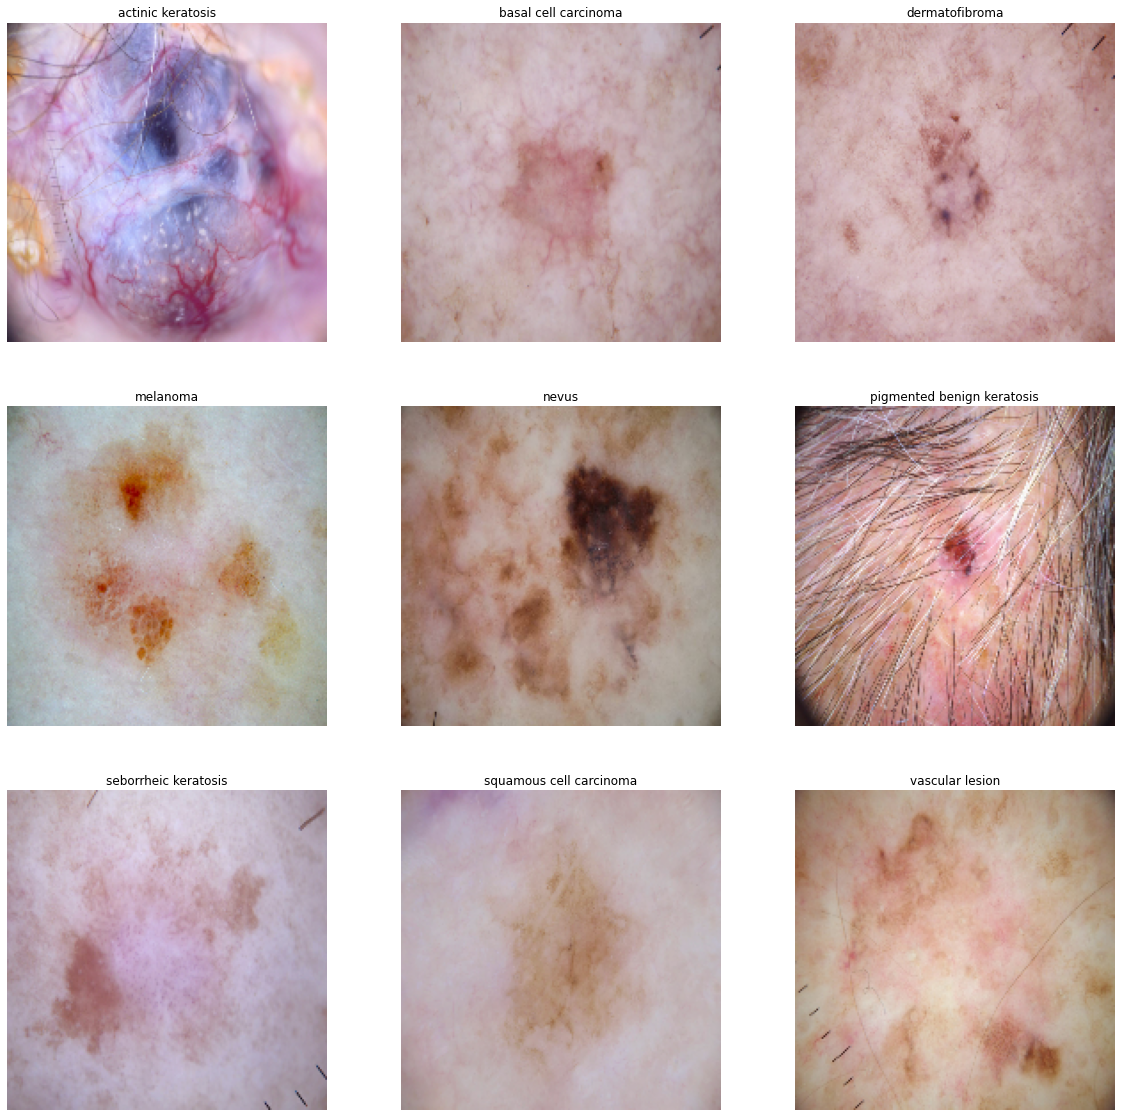

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
for images,labels in train_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")


  


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [ ]:
for image_batch,labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
### Your code goes here

normalization = layers.experimental.preprocessing.Rescaling(1./255)


In [ ]:
normalized = train_ds.map(lambda x, y: (normalization(x), y))
image_batch, labels_batch = next(iter(normalized))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.9715687


In [ ]:
num_classes = 9
model = Sequential([layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)),
                    layers.Conv2D(16,kernel_size=(3,3),padding='same',strides=(1,1),activation='relu'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(32,kernel_size=(3,3),padding='same',strides=(1,1),activation='relu'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(64,kernel_size=(3,3),padding='same',strides=(1,1),activation='relu'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Flatten(),
                    layers.Dense(128,activation='softmax'),
                    layers.Dense(num_classes)])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 22, 22, 64)       

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 2s 23ms/step - loss: 2.1350 - accuracy: 0.1719 - val_loss: 2.1211 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 1s 20ms/step - loss: 2.0993 - accuracy: 0.2065 - val_loss: 2.0934 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 1s 20ms/step - loss: 2.0757 - accuracy: 0.2065 - val_loss: 2.0739 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 1s 20ms/step - loss: 2.0584 - accuracy: 0.2065 - val_loss: 2.0591 - val_accuracy: 0.2058
Epoch 5/20
56/56 [==============================] - 1s 20ms/step - loss: 2.0457 - accuracy: 0.2065 - val_loss: 2.0487 - val_accuracy: 0.2058
Epoch 6/20
56/56 [==============================] - 1s 20ms/step - loss: 2.0366 - accuracy: 0.2065 - val_loss: 2.0407 - val_accuracy: 0.2058
Epoch 7/20
56/56 [==============================] - 1s 20ms/step - loss: 2.0300 - accuracy: 0.2065 - val_loss: 2.0355 - val_accuracy: 0.2058
Epoch 8/20
56

### Visualizing training results

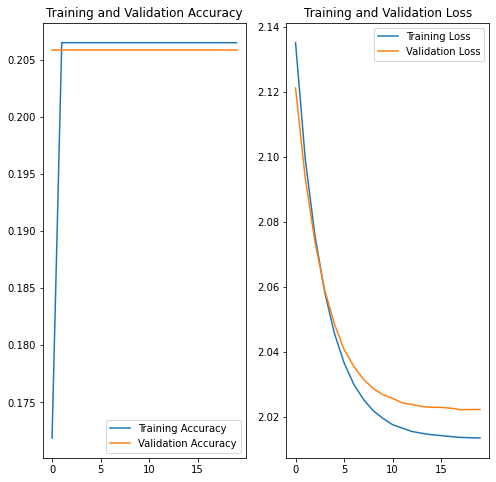

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Inference:- From the above plots, we can infer that the training accuracy is increasing and it stopped at a particular point and became saturated. The validation accuracy is stationary . This infers that the model is overfitted

#### The training accuracy is increasing linearly whereas the validation accuracy is stationary .Also, the difference between training accuracy and validation accuracy is large .Hence, this model is overfitting model

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
dataaugmentation = keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
                                     layers.experimental.preprocessing.RandomRotation(0.1,interpolation='bilinear'),
                                     layers.experimental.preprocessing.RandomZoom(0.1,interpolation='bilinear')])

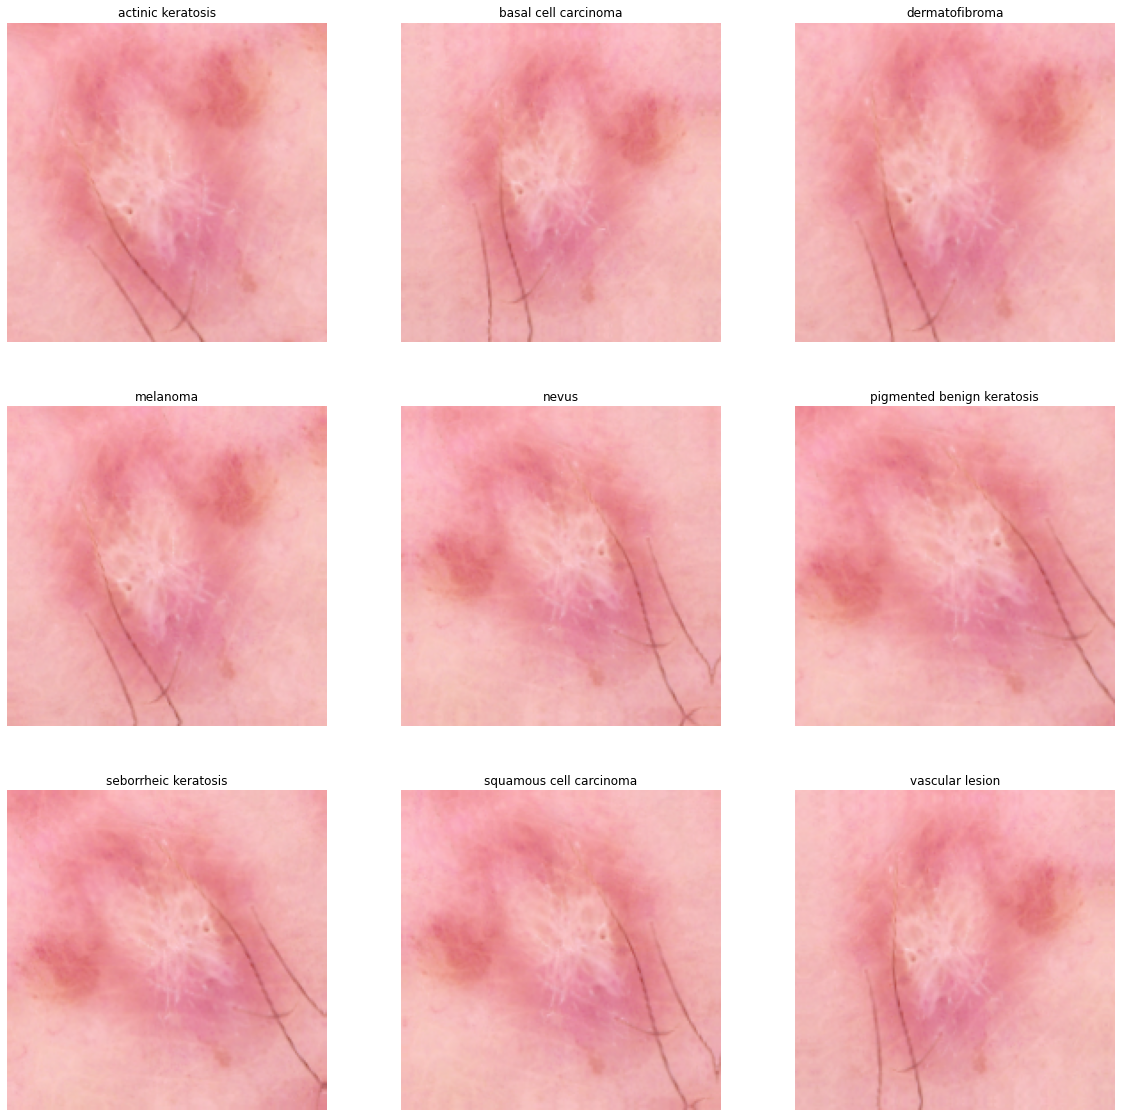

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(20,20))
for images,_ in train_ds.take(1):
  for i in range(9):
    aug_images = dataaugmentation(images)
    ax=plt.subplot(3,3,i+1)
    plt.imshow(aug_images[0].numpy().astype('uint8'))
    plt.title(class_names[i])
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential([dataaugmentation,
                    layers.experimental.preprocessing.Rescaling(1./255),
                    layers.Conv2D(16,kernel_size=(3,3),padding='same',strides=(1,1),activation='relu'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(32,kernel_size=(3,3),padding='same',strides=(1,1),activation='relu'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(64,kernel_size=(3,3),padding='same',strides=(2,2),activation='relu'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Dropout(0.2),
                    layers.Flatten(),
                    layers.Dense(128,activation='softmax'),
                    layers.Dense(num_classes)])


### Compiling the model

In [ ]:
## Your code goes here
model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 23, 23, 64)       

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs=20
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/20
56/56 [==============================] - 2s 24ms/step - loss: 2.1436 - accuracy: 0.1948 - val_loss: 2.1243 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 1s 20ms/step - loss: 2.1068 - accuracy: 0.2042 - val_loss: 2.0959 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 1s 20ms/step - loss: 2.0820 - accuracy: 0.2065 - val_loss: 2.0755 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 1s 20ms/step - loss: 2.0636 - accuracy: 0.2065 - val_loss: 2.0607 - val_accuracy: 0.2058
Epoch 5/20
56/56 [==============================] - 1s 20ms/step - loss: 2.0503 - accuracy: 0.2065 - val_loss: 2.0501 - val_accuracy: 0.2058
Epoch 6/20
56/56 [==============================] - 1s 20ms/step - loss: 2.0404 - accuracy: 0.2065 - val_loss: 2.0419 - val_accuracy: 0.2058
Epoch 7/20
56/56 [==============================] - 1s 20ms/step - loss: 2.0332 - accuracy: 0.2065 - val_loss: 2.0362 - val_accuracy: 0.2058
Epoch 8/20
56

### Visualizing the results

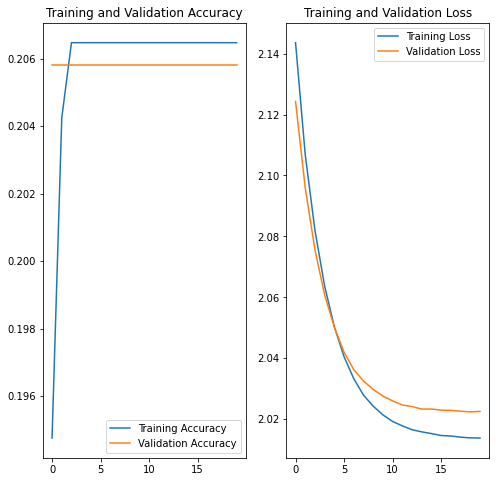

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Inference:-** There is some improvement in the model as compared to the previous model run as the training accuracy is lineraly increasing and the validation accuracy has come down near to the training accuracy

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Your code goes here.

from glob import glob
list_of_path = [x for x in glob(os.path.join(data_dir_train,"*","*.jpg"))]
list_of_path

['/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0024475.jpg',
 '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0024662.jpg',
 '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0025596.jpg',
 '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0025578.jpg',
 '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0025197.jpg',
 '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0025452.jpg',
 '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0024904.jpg',

In [ ]:
find_path = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train,"*","*.jpg"))]
find_path

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [ ]:
len(find_path)

2239

In [ ]:
type(find_path)

list

In [ ]:
original_dataframe = dict(zip(list_of_path,find_path))
original_dataframe

{'/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0024475.jpg': 'vascular lesion',
 '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0024662.jpg': 'vascular lesion',
 '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0025596.jpg': 'vascular lesion',
 '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0025578.jpg': 'vascular lesion',
 '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0025197.jpg': 'vascular lesion',
 '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0025452.jpg': 'vascular lesion',
 '/content/drive/MyDrive/CNN

In [ ]:
df_original = pd.DataFrame(list(original_dataframe.items()),columns=["path","label"])
df_original.head()

,path,label
0,/content/drive/MyDrive/CNN_assignment/Skin can...,vascular lesion
1,/content/drive/MyDrive/CNN_assignment/Skin can...,vascular lesion
2,/content/drive/MyDrive/CNN_assignment/Skin can...,vascular lesion
3,/content/drive/MyDrive/CNN_assignment/Skin can...,vascular lesion
4,/content/drive/MyDrive/CNN_assignment/Skin can...,vascular lesion


In [ ]:
df_original.shape

(2239, 2)

In [ ]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
df_original['skin_labels'] = labelencoder.fit_transform(df_original['label'])
df_original

,path,label,skin_labels
0,/content/drive/MyDrive/CNN_assignment/Skin can...,vascular lesion,8
1,/content/drive/MyDrive/CNN_assignment/Skin can...,vascular lesion,8
2,/content/drive/MyDrive/CNN_assignment/Skin can...,vascular lesion,8
3,/content/drive/MyDrive/CNN_assignment/Skin can...,vascular lesion,8
4,/content/drive/MyDrive/CNN_assignment/Skin can...,vascular lesion,8
...,...,...,...
2234,/content/drive/MyDrive/CNN_assignment/Skin can...,nevus,4
2235,/content/drive/MyDrive/CNN_assignment/Skin can...,nevus,4
2236,/content/drive/MyDrive/CNN_assignment/Skin can...,nevus,4
2237,/content/drive/MyDrive/CNN_assignment/Skin can...,nevus,4


In [67]:
import seaborn as sns

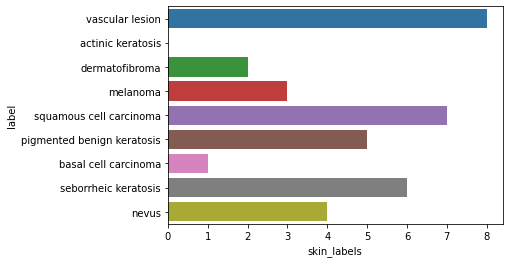

In [69]:
sns.barplot(y='label',x='skin_labels',data=df_original)
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
####  Ans: Actinic keratosis has the least number of samples
#### - Which classes dominate the data in terms proportionate number of samples?
####  Ans: **Vascular Lesion,Squamous cell carcinoma dominate the data in terms of proportionate number of samples**

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [70]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [71]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [74]:
path_to_training_dataset="/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F07C22FA250>: 100%|██████████| 500/500 [00:19<00:00, 26.13 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0844EC2510>: 100%|██████████| 500/500 [00:18<00:00, 26.91 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F07C22AE390>: 100%|██████████| 500/500 [00:18<00:00, 26.62 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F07E6599750>: 100%|██████████| 500/500 [01:33<00:00,  5.34 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F0774117690>: 100%|██████████| 500/500 [01:14<00:00,  6.67 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F07C223BB90>: 100%|██████████| 500/500 [00:19<00:00, 25.38 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F0844DE19D0>: 100%|██████████| 500/500 [00:43<00:00, 11.57 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F07F81277D0>: 100%|██████████| 500/500 [00:19<00:00, 26.03 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F07C230FD90>: 100%|██████████| 500/500 [00:19<00:00, 25.70 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [75]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [79]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033450.jpg_fa21309a-1994-4f37-bc65-e018b8984059.jpg',
 '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032545.jpg_e1106673-6063-444b-9ff9-5ec0f46915e0.jpg',
 '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033749.jpg_7049d9dc-156c-4327-9d04-7917eeae5178.jpg',
 '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026713.jpg_bcbb7f00-5533-40d3-afee-6a65c9b6dfad.jpg',
 '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascu

In [80]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [81]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [82]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df_original.append(df2)

In [83]:
new_df['Label'].value_counts()

vascular lesion               500
actinic keratosis             500
squamous cell carcinoma       500
pigmented benign keratosis    500
dermatofibroma                500
basal cell carcinoma          500
melanoma                      500
seborrheic keratosis          500
nevus                         500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [91]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [93]:
data_dir_train = "/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [94]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [95]:
## your code goes here
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [96]:
normalized_1 = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_1))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.3179738 0.93382317


In [100]:
num_classes = 9
model = Sequential([layers.experimental.preprocessing.Rescaling(1./255),
                    layers.Conv2D(16,kernel_size=(3,3),padding='same',strides=(2,2),activation='relu',input_shape=(img_height,img_width,3)),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(32,kernel_size=(3,3),padding='same',strides=(2,2),activation='relu'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(64,kernel_size=(3,3),padding='same',strides=(2,2),activation='relu'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Dropout(0.2),
                    layers.Flatten(),
                    layers.Dense(128,activation='softmax'),
                    layers.Dense(num_classes)])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [101]:
## your code goes here

model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [102]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs)

Epoch 1/50
169/169 [==============================] - 30s 168ms/step - loss: 2.1853 - accuracy: 0.1447 - val_loss: 2.1862 - val_accuracy: 0.1707
Epoch 2/50
169/169 [==============================] - 28s 162ms/step - loss: 2.1078 - accuracy: 0.2179 - val_loss: 2.0587 - val_accuracy: 0.2183
Epoch 3/50
169/169 [==============================] - 29s 169ms/step - loss: 2.0238 - accuracy: 0.2431 - val_loss: 1.9846 - val_accuracy: 0.2301
Epoch 4/50
169/169 [==============================] - 30s 172ms/step - loss: 1.9750 - accuracy: 0.2489 - val_loss: 1.9575 - val_accuracy: 0.2316
Epoch 5/50
169/169 [==============================] - 28s 163ms/step - loss: 1.9458 - accuracy: 0.2467 - val_loss: 1.9665 - val_accuracy: 0.2160
Epoch 6/50
169/169 [==============================] - 30s 172ms/step - loss: 1.9178 - accuracy: 0.2511 - val_loss: 1.9043 - val_accuracy: 0.2368
Epoch 7/50
169/169 [==============================] - 29s 164ms/step - loss: 1.9028 - accuracy: 0.2530 - val_loss: 1.9152 - val_ac

#### **Todo:**  Visualize the model results

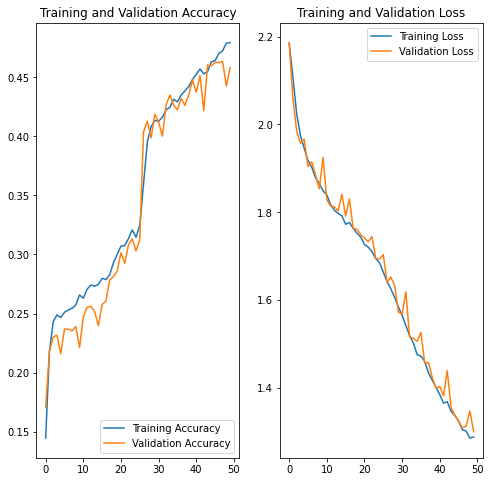

In [103]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



#### The above plots infer that the model is better than the before model as , we have overcame the problem of overfitting and the class rebalance helped the model to perform better and to achieve better accuracy .So, overall the model is good